In [212]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Preprocessing:
## First phase:

In [197]:
traindata_df = pd.read_csv('trainData.csv', header=None)
traintag_df = pd.read_csv('trainLabels.csv', header=None)
testdata_df = pd.read_csv('testData.csv', header=None)
testtag_df = pd.read_csv('testLabels.csv', header=None)
traintag_df.columns = ['tag']
testtag_df.columns = ['tag']
traindata_df.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,119,114,130,76,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,22,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,33,96,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


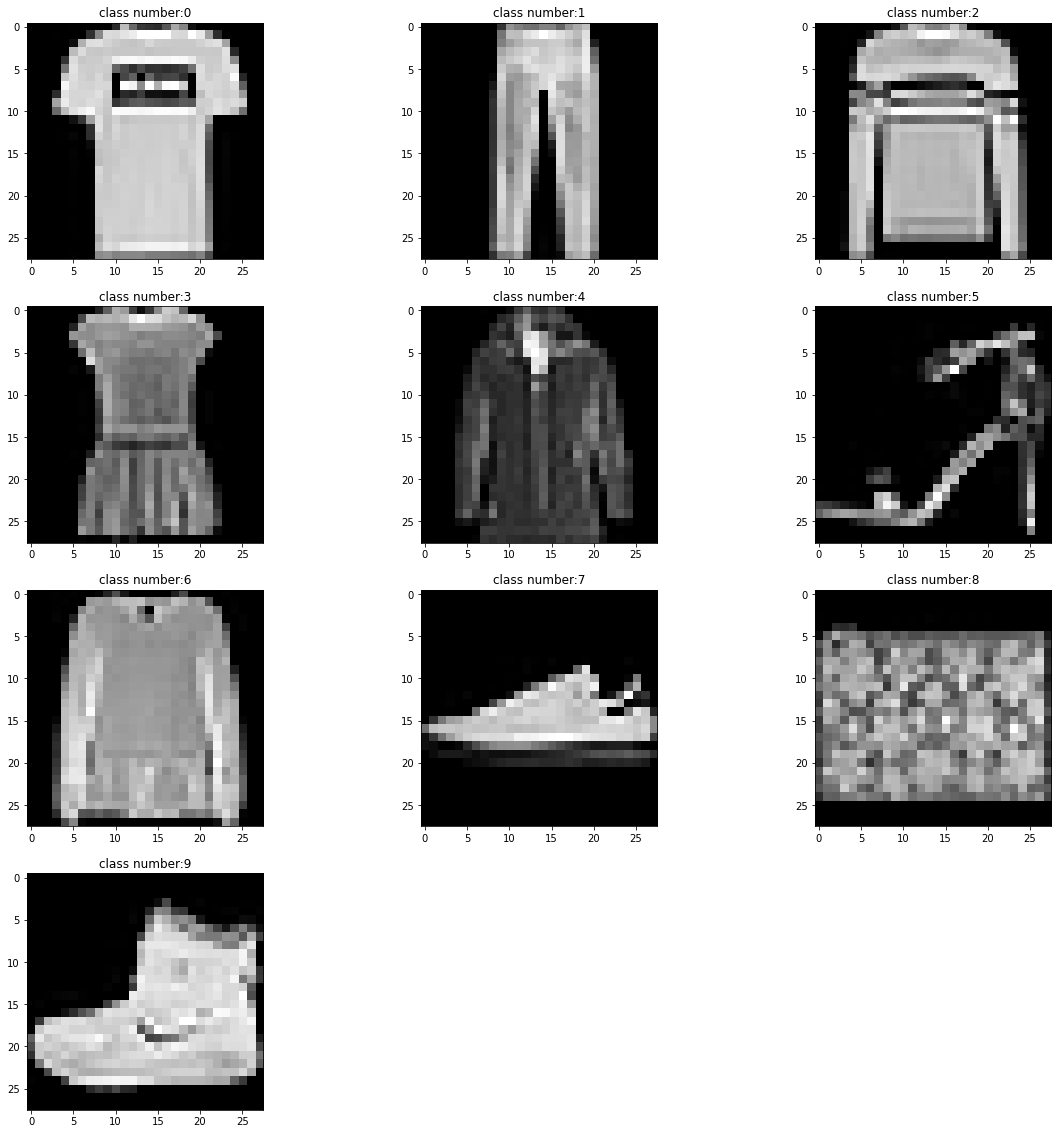

In [198]:
def reshape_data(inp):
    return np.reshape(inp, (28,28))


train_tag_list = list()
test_tag_list = list()
plt.figure(figsize=(20,20))
models = list(traintag_df['tag'].unique())
for c_count in range(len(models)):
    matched_index = traintag_df.index[traintag_df['tag'] == c_count].tolist()[0]
    train_tag_list.append(traintag_df.index[traintag_df['tag'] == c_count].tolist())
    test_tag_list.append(testtag_df.index[testtag_df['tag'] == c_count].tolist())
    reshaped_row = reshape_data(traindata_df.iloc[matched_index].to_numpy())
    plt.subplot(4,3,c_count+1)
    plt.imshow(reshaped_row, cmap=plt.cm.gray)
    plt.title('class number:{}'.format(c_count))

## Second Phase:

Text(0.5, 1.0, 'Test Data')

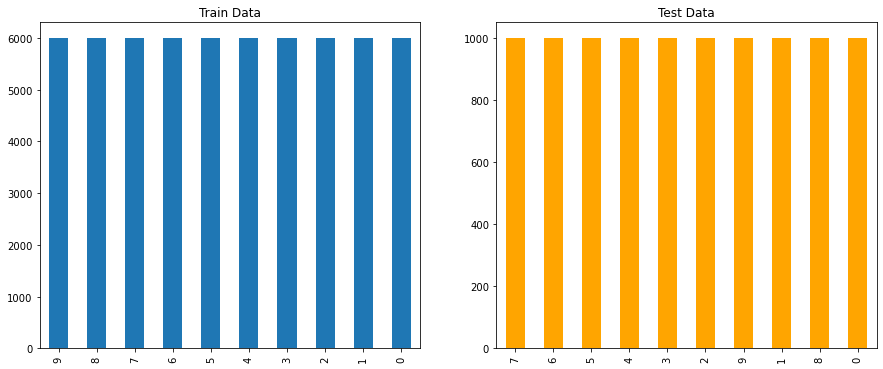

In [144]:
np.random.seed(20)


trains_count = traintag_df['tag'].value_counts()
tests_count = testtag_df['tag'].value_counts()

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
ax = (traintag_df['tag'].value_counts()).plot(kind='bar')
plt.title("Train Data")
# ax.set_yticks([0, 1000, 2000, 3000, 4000, 5000, 6000])
plt.subplot(1,2,2)
ax2 = (testtag_df['tag'].value_counts()).plot(kind='bar', color='orange')
plt.title("Test Data")
# ax2.set_yticks([0, 1000, 2000, 3000, 4000, 5000, 6000])

## Third Phase:
<p>We should normalize data to obtain a mean close to 0. Normalizing the data generally speeds up learning and leads to faster convergence.Also, normalization ensures that the magnitude of the values that a feature assumes are more or less the same. At first when weights are initialized, those features with high mean will have the upper hand. Also, it is worth mentioning that by using big numbers(such as 255 or etc) we might reach exploiding gradiesnts sooner than expected!
</p>

In [145]:
traindata_df = traindata_df.div(255)
testdata_df = testdata_df.div(255)

traindata_df = traindata_df.to_numpy()
testdata_df = testdata_df.to_numpy()
traintag_df = traintag_df.to_numpy().reshape(-1)
testtag_df = testtag_df.to_numpy().reshape(-1)

# Part 2

### Utility Functions

## Dataloader - done
<p> For onehot function, pandas get_dummies has been used in order to expand the tag matrix. Note that this method also works on matrixes along it's core dataframe input type.</p>
<p> For suffle_dataset, a generator has been used to shuffle indexes and then we overwrite both datasets using the suffled indexs that we have created.</p>

In [146]:
class Dataloader:
    
    def __init__(self, data, labels, n_classes, batch_size=None, shuffle=False):
        assert len(data)==len(labels)
        self.__n_classes = n_classes
        self.__batch_size = batch_size
        self.__shuffle = shuffle
        self.__data = np.copy(data)
        self.__onehot_labels = self.__onehot(labels, self.__n_classes)
    
    def __onehot(self, labels, n_classes):
        onehot_vectors = np.matrix(pd.get_dummies(labels, columns = ['tag'], drop_first = False))
        return onehot_vectors
    
    def __shuffle_dataset(self):
        size = len(self.__data)
        generator = np.random.permutation(size)
        self.__data = np.array(self.__data)
        self.__data = self.__data[generator]
        self.__onehot_labels = np.array(self.__onehot_labels)
        self.__onehot_labels = self.__onehot_labels[generator]
            
        
    def __iter__(self):
        
        if self.__shuffle:
            self.__shuffle_dataset()
            
        if self.__batch_size==None:
            yield (np.matrix(self.__data), np.matrix(self.__onehot_labels))
            return
            
        for idx in range(0, len(self.__data), self.__batch_size):
            yield (np.matrix(self.__data[idx:idx+self.__batch_size]), 
                   np.matrix(self.__onehot_labels[idx:idx+self.__batch_size]))

## Activation Functions - done

In [147]:
class Identical:
    
    def __init__(self): pass

    def __val(self, matrix):
        identical_value = np.matrix(matrix, dtype=float)
        return identical_value

    def derivative(self, matrix):
        temp = np.matrix(matrix, dtype=float)
        identical_derivative = np.matrix(np.full(np.shape(temp), 1.))
        return identical_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)
    
class Relu:
    
    def __init__(self): pass
    
    def __relu(self, matrix):
        temp = np.matrix(matrix, dtype=float)
        relu_value = np.maximum(temp, 0)
        return relu_value

    def derivative(self, matrix):
        temp = np.matrix(matrix, dtype=float)
        relu_derivative = (matrix >= 0) * 1
        return relu_derivative
    
    def __call__(self, matrix):
        return self.__relu(matrix)

    
class LeakyRelu:
    
    def __init__(self, negative_slope=0.01):
        self.negative_slope = 0.01
    
    def __val(self, matrix):
        leacky_relu_value = np.maximum(self.negative_slope * matrix, matrix)
        return leacky_relu_value

    def derivative(self, matrix):
        leacky_relu_derivative = np.zeros_like(matrix)
        leacky_relu_derivative[matrix<=0]= self.negative_slope
        leacky_relu_derivative[matrix>0]= 1
        return leacky_relu_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)

    
class Sigmoid:
    
    def __init__(self): pass

    def __val(self, matrix):
        temp = np.matrix(matrix, dtype=float)
        sigmoid_value = 1/(1 + np.exp(-temp))
        return sigmoid_value

    def derivative(self, matrix):
        sig_val = 1 / (1 + np.exp(-matrix))
        sigmoid_derivative = np.multiply(sig_val , (1 - sig_val))
        return sigmoid_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)

        

class Softmax:
    
    def __init__(self): pass
    
    def first_step(self, matrix):
        temp = np.matrix(matrix, dtype=float)
        z = np.exp(matrix - np.max(matrix))
        value = z / np.sum(z)
        return value
        
    def __val(self, matrix):
        temp = np.matrix(matrix, dtype=float)
        softmax_value = np.apply_along_axis(self.first_step, 1, matrix)
        return softmax_value
    
    def derivative(self, matrix):
        temp = np.matrix(matrix, dtype=float)
        exps = np.exp(temp)
        normal_soft =  exps / np.sum(exps)
        s = normal_soft.reshape(-1,1)
        softmax_derivative =  np.diagflat(s) - np.dot(s, s.T)
        return softmax_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)

    
class Tanh:
    
    def __init__(self): pass

    def __val(self, matrix):
        temp = np.matrix(matrix, dtype=float)
        tanh_value = np.tanh(temp)
        return tanh_value

    def derivative(self, matrix):
        temp = 1 / np.cosh(matrix)
        tanh_derivative = np.multiply(temp, temp)
        return tanh_derivative
    
    def __call__(self, matrix):
        return self.__val(matrix)

## Loss Function - done
<p> Gradient descent is a first-order iterative optimization algorithm for finding a local minimum of a differentiable function. The idea is to take repeated steps in the opposite direction of the gradient (or approximate gradient) of the function at the current point, because this is the direction of steepest descent.</p>

In [148]:
class CrossEntropy:
    
    def __init__(self): pass
    
    def __val(self, true_val, expected_val):
        assert np.shape(true_val)==np.shape(expected_val)
        function = Softmax()
        y = function(true_val)
        y_log = np.log(y)
        log_lost = np.multiply(expected_val, y_log)
        cross_entropy_value = np.sum(log_lost, axis=1)
        cross_entropy_value = -1 * cross_entropy_value
        return np.mean(cross_entropy_value)
    
    def derivative(self, true_val, expected_val):
        assert np.shape(true_val) == np.shape(expected_val)
#         z = expected_val.argmax(axis=1)
#         size = z.shape[0]
        function = Softmax()
        soft_val = function(true_val)
#         grad = soft_val
#         grad[range(size),z] -= 1
#         grad = grad/size
        cross_entropy_derivative = soft_val - expected_val
        return cross_entropy_derivative
    
    def __call__(self, true_val, expected_val):
        return self.__val(true_val, expected_val)

## Layer -  done

<p> <b>Forward method:</b> There are four fields in each layer that should be kept and tracked. We can see these four fields in the constructor of layer class. By calling forward, since we are moving a step further, last_input will be changed to layer_input and last_activation_input will also change to product of layer_input and weights added with bias to adjust. The result would be given to activation method kept in class and finally, derivative of it would be calculated and stored in last_activation_derivative </p>
<p> <b>Update weights:</b> We first multiply derivative of activation function and provided input which is basically derivative of next layer. Then the output should be multiplied with current weights. Result would be backprop_tensor that should be returned. Also weight and bias should be updated based on observations. Learning rate * mean of result should be subtracted from bias and Learning Rate * multiplication of crossed and weights should be subtracted from weights. Both these values must be normalized in order to prevent buggy results.</p>

<p> <b>Distributions:</b> He initialization is used to prevent gradient. Uniform will be calculated by averaging number of input and output and then dividing two by the result. Normal is a bit simplers since it says mean should be zero and variance should be reuslt of dividing two by size of input. </p>

In [149]:
class Layer:

    DEFAULT_LOW, DEFAULT_HIGH, DEFAULT_MEAN, DEFAULT_VAR = 0, 0.05, 0., 1.
  
    def __init__(self, output_size, input_size, 
                 activation=Identical(), initial_weight='uniform', **initializing_parameters):
        
        self.__weight_initializer_dict = {'uniform':self.__uniform_weight, 'normal':self.__normal_weight}
        assert type(initial_weight)==str, 'Undefined activation function!'
        assert initial_weight in self.__weight_initializer_dict, 'Undefined weight initialization function!' 
        
        
        self.__n_neurons = output_size
        self.__total = input_size + output_size
        
        weight_initializer = self.__weight_initializer_dict[initial_weight]
        self.__weight = weight_initializer(self.__n_neurons, input_size, **initializing_parameters)
        self.__bias = weight_initializer(1, self.__n_neurons, **initializing_parameters)
        self.__activation = activation
        
        self.__last_input = None
        self.__last_activation_input = None
        self.__last_activation_output = None
        self.__last_activation_derivative = None
        
        
    def forward(self, layer_input):
        assert np.ndim(layer_input) == 2
        assert np.size(self.__weight, 1) == np.size(layer_input, 1)
        w_t = self.__weight.T
        
        self.__last_input = layer_input        
        self.__last_activation_input = np.dot(layer_input, w_t)
        self.__last_activation_input = self.__last_activation_input + self.__bias
        self.__last_activation_output = self.__activation(self.__last_activation_input)
        self.__last_activation_derivative = self.__activation.derivative(self.__last_activation_input)
        
        return self.__last_activation_output
    
    def update_weights(self, backprop_tensor, lr):
        assert np.ndim(backprop_tensor) == 2
        assert np.size(backprop_tensor, 0) == np.size(self.__last_activation_input, 0) # batch_size
        assert np.size(backprop_tensor, 1) == self.__n_neurons
        
        w_t = self.__weight.T
        input_t = self.__last_input.T
        crossed = np.multiply(backprop_tensor, self.__last_activation_derivative)
        crossed_t = crossed.T
        weight_lr_coeff = np.dot(crossed.T, self.__last_input)
        backprop_tensor = np.dot(crossed, self.__weight)
        
        crossed_sum = np.sum(crossed, axis = 0)
        b_value_change = lr * np.squeeze(crossed_sum) / len(self.__last_input)
        self.__bias = self.__bias - b_value_change
        
        w_value_change = lr * weight_lr_coeff / len(self.__last_activation_input)
        self.__weight = self.__weight - w_value_change
        return backprop_tensor

    def __uniform_weight(self, dim1, dim2, **initializing_parameters):
        low, high = self.DEFAULT_LOW, self.DEFAULT_HIGH        
        if 'low' in initializing_parameters.keys(): low = initializing_parameters['low']
        if 'high' in initializing_parameters.keys(): high = initializing_parameters['high']
        weights = np.random.uniform(low, (4 / self.__total), (dim1, dim2))
        return weights

    def __normal_weight(self, dim1, dim2, **initializing_parameters):
        mean, var = self.DEFAULT_MEAN, self.DEFAULT_VAR
        if 'mean' in initializing_parameters.keys(): mean = initializing_parameters['mean']
        if 'var' in initializing_parameters.keys(): var = initializing_parameters['var']
        dim_val = 2 / dim1
        he_denom = np.sqrt(dim_val)
        weights = np.random.randn(dim1, dim2)
        weights = weights / he_denom
        return weights
    
    @property
    def n_neurons(self): return self.__n_neurons
    
    @property
    def weight(self): return self.__weight
    
    @property
    def bias(self): return self.__bias
    
    @property
    def activation(self): return self.__activation

## Feed Forward Neural Network

In [164]:
class FeedForwardNN:
    
    def __init__(self, input_shape):
        self.__input_shape = input_shape
        self.__output_shape = None
        self.__layers_list = []
        self.__lr = None
        self.__loss = None

        
    def add_layer(self, n_neurons, activation=Relu(), initial_weight='uniform', **initializing_parameters):
         
        assert type(n_neurons)==int, "Invalid number of neurons for the layer!"
        assert n_neurons>0, "Invalid number of neurons for the layer!"
        n_prev_neurons = self.__input_shape if len(self.__layers_list)==0 else self.__layers_list[-1].n_neurons
        new_layer = Layer(n_neurons, n_prev_neurons, activation, initial_weight, **initializing_parameters)
        self.__layers_list.append(new_layer)
        self.__output_shape = self.__layers_list[-1].n_neurons 
      
    
    def set_training_param(self, loss=CrossEntropy(), lr=1e-3):
        assert self.__layers_list, "Uncomplete model!"
        self.__loss = loss
        self.__lr = lr
    
    
    def forward(self, network_input):
        assert type(self.__output_shape) != None, "Model is not compiled!"
        inp = network_input
        for i in range(len(self.__layers_list)):
            element = self.__layers_list[i]
            inp = element.forward(inp)
        return inp
    
    
    def fit(self, epochs, trainloader, testloader=None, print_results=True):
        
        assert type(self.__output_shape) != None, "Model is not compiled!"
        assert type(self.__lr) != None and type(self.__loss) != None, "Training paramenters are not set!"
        log = {"train_accuracy":[], "train_loss":[], "test_accuracy":[], "test_loss":[]}
        for epoch in range(1, epochs+1):
            if print_results: 
                print('Epoch {}:'.format(epoch)) 
            average_accuracy, average_loss = self.__train(trainloader)
            log['train_accuracy'].append(average_accuracy)
            log['train_loss'].append(average_loss)
            if print_results:
                print('\tTrain: Average Accuracy: {:.4f}\t   Average Loss: {:.4f}'.format(average_accuracy, average_loss))
            if type(testloader) != type(None):
                average_accuracy, average_loss = self.__test(testloader)
                log['test_accuracy'].append(average_accuracy)
                log['test_loss'].append(average_loss)
                if print_results:
                    print('\tTest:  Average Accuracy: {:.4f}\t   Average Loss: {:.4f}'.format(average_accuracy, average_loss))         
        return log
    

    def second_layer(self, input_data, input_type):
        first_layer = self.__layers_list[0]
        second_layerd = self.__layers_list[1]
        output = first_layer.forward(input_data)
        output = second_layerd.forward(output)
        w = self.__layers_list[1].weight
        return (w, output)

    
    def __train(self, trainloader):
        batch_accuracies, batch_losses = [], []
        for x_train, y_train in trainloader:
            batch_accuracy, batch_loss = self.__train_on_batch(x_train, y_train)
            batch_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return np.mean(batch_accuracies), np.mean(batch_losses)
    
    
    def __test(self, testloader):
        batch_accuracies, batch_losses = [], []
        for x_test, y_test in testloader:
            batch_accuracy, batch_loss = self.__test_on_batch(x_test, y_test)
            batch_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return [np.mean(batch_accuracies), np.mean(batch_losses)]

    def __train_on_batch(self, x_batch, y_batch):
        x_proccessed = self.forward(x_batch)
        self.__update_weights(x_proccessed, y_batch)
        batch_average_loss = self.__loss(x_proccessed, y_batch)
        batch_accuracy = self.__compute_accuracy(x_proccessed, y_batch)
        return (batch_accuracy, batch_average_loss)
            
    def __test_on_batch(self, x_batch, y_batch):
        x_proccessed = self.forward(x_batch)
        batch_average_loss = self.__loss(x_proccessed, y_batch)
        batch_accuracy = self.__compute_accuracy(x_proccessed, y_batch)
        return (batch_accuracy, batch_average_loss)
               
    def __get_labels(self, outputs):
        labels = np.argmax(outputs, axis=1)
        labels = np.array(labels)
        return labels
    
    def __compute_accuracy(self, output, expected_output):
        corrects = 0
        expected_output = np.array(np.argmax(expected_output, axis=1))
        converted_output = self.__get_labels(output)
        for j in range(len(converted_output)):
            if (converted_output[j] == expected_output[j]):
                corrects += 1
        return corrects / len(output)
    
    def __update_weights(self, output, y_train):
        derivative = self.__loss.derivative(output, y_train)
        reversed_arr = list(reversed(self.__layers_list))
        for i in range(len(reversed_arr)):
            derivative = reversed_arr[i].update_weights(derivative, self.__lr)
    

# Part 3

## First phase:  best settings.

In [151]:
INPUT_SHAPE = traindata_df.shape[1]
LEARNING_RATE = 0.03
EPOCHS = 30
BATCH_SIZE = 32
TRAINLOADER = Dataloader(traindata_df, traintag_df, n_classes=10, batch_size=BATCH_SIZE, shuffle=True)
TESTLOADER = Dataloader(testdata_df, testtag_df, n_classes=10, batch_size=BATCH_SIZE, shuffle=True)


network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(40, activation=Relu(), weight_initializer='uniform')
network.add_layer(20, activation=Relu(), weight_initializer='uniform')
network.add_layer(10, activation=Identical(),  weight_initializer='normal')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

Epoch 1:
	Train: Average Accuracy: 0.4818	   Average Loss: 1.3396
	Test:  Average Accuracy: 0.6958	   Average Loss: 0.8209
Epoch 2:
	Train: Average Accuracy: 0.7610	   Average Loss: 0.6875
	Test:  Average Accuracy: 0.7944	   Average Loss: 0.6253
Epoch 3:
	Train: Average Accuracy: 0.8149	   Average Loss: 0.5439
	Test:  Average Accuracy: 0.8212	   Average Loss: 0.5130
Epoch 4:
	Train: Average Accuracy: 0.8373	   Average Loss: 0.4705
	Test:  Average Accuracy: 0.8206	   Average Loss: 0.5014
Epoch 5:
	Train: Average Accuracy: 0.8485	   Average Loss: 0.4304
	Test:  Average Accuracy: 0.8397	   Average Loss: 0.4509
Epoch 6:
	Train: Average Accuracy: 0.8555	   Average Loss: 0.4054
	Test:  Average Accuracy: 0.8490	   Average Loss: 0.4362
Epoch 7:
	Train: Average Accuracy: 0.8607	   Average Loss: 0.3868
	Test:  Average Accuracy: 0.8537	   Average Loss: 0.4092
Epoch 8:
	Train: Average Accuracy: 0.8669	   Average Loss: 0.3711
	Test:  Average Accuracy: 0.8582	   Average Loss: 0.4017
Epoch 9:
	Train:

In [152]:
def print_log(log):
    print('Fifth Result of NN:')
    print('Train Accuracy:', "{:.2f}".format(log['train_accuracy'][5]), '  ',
          'Test Accuracy:', "{:.2f}".format(log['test_accuracy'][5]))
    print('Train Loss:', "{:.2f}".format(log['train_loss'][5]), '  ',
          'Test Loss:', "{:.2f}".format(log['test_loss'][5]))

    print('Final Result of NN:')
    print('Train Accuracy:', "{:.2f}".format(log['train_accuracy'][-1]), '  ',
          'Test Accuracy:', "{:.2f}".format(log['test_accuracy'][-1]))
    print('Train Loss:', "{:.2f}".format(log['train_loss'][-1]), '  ',
          'Test Loss:', "{:.2f}".format(log['test_loss'][-1]))

## Second phase:

### Learinig Rate = 0.003
<p> Decreasing LR will result in slower process since adjusments are too tiny to make a significant progress within a single epoch and as a result there is the risk of not reaching a good model.  As we can see below, accuracy of the fifth epoch is still under 60% which is poor compared to other LRs.

In [154]:
INPUT_SHAPE = traindata_df.shape[1]
LEARNING_RATE = 0.003
EPOCHS = 30
BATCH_SIZE = 32
TRAINLOADER = Dataloader(traindata_df, traintag_df, n_classes=10, batch_size=BATCH_SIZE, shuffle=True)
TESTLOADER = Dataloader(testdata_df, testtag_df, n_classes=10, batch_size=BATCH_SIZE, shuffle=True)


network = FeedForwardNN(INPUT_SHAPE)
# network.add_layer(20, activation=Relu(), weight_initializer='uniform')
# network.add_layer(10, weight_initializer='normal')

network.add_layer(40, activation=Relu(), weight_initializer='uniform')
network.add_layer(20, activation=Relu(), weight_initializer='uniform')
network.add_layer(10, activation=Identical(), weight_initializer='normal')

network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)


log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER, print_results=False)
print_log(log)

Fifth Result of NN:
Train Accuracy: 0.59    Test Accuracy: 0.59
Train Loss: 1.07    Test Loss: 1.05
Final Result of NN:
Train Accuracy: 0.85    Test Accuracy: 0.84
Train Loss: 0.44    Test Loss: 0.47


### Learinig Rate = 0.3
<p> One advantage when we increase LR is that the process will take less time since values tend to change faster during each update. One drawback is that by increasing LR we are also increasing the risk of not getting a good answer. The main reason is that the process might get stuck in a situation where NN thinks is a maximum but in fact it is not. Another drawback is that we might do unneccessary adjustments (since LR is high) to weights and bias and ruin the gradient.

In [155]:
INPUT_SHAPE = traindata_df.shape[1]
LEARNING_RATE = 0.3
EPOCHS = 30
BATCH_SIZE = 32
TRAINLOADER = Dataloader(traindata_df, traintag_df, n_classes=10, batch_size=BATCH_SIZE, shuffle=True)
TESTLOADER = Dataloader(testdata_df, testtag_df, n_classes=10, batch_size=BATCH_SIZE, shuffle=True)


network = FeedForwardNN(INPUT_SHAPE)
# network.add_layer(20, activation=Relu(), weight_initializer='uniform')
# network.add_layer(10, weight_initializer='normal')

network.add_layer(40, activation=Relu(), weight_initializer='uniform')
network.add_layer(20, activation=Relu(), weight_initializer='uniform')
network.add_layer(10, activation=Identical(), weight_initializer='normal')

network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)


log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER, print_results=False)
print_log(log)

Fifth Result of NN:
Train Accuracy: 0.85    Test Accuracy: 0.74
Train Loss: 0.43    Test Loss: 0.82
Final Result of NN:
Train Accuracy: 0.88    Test Accuracy: 0.85
Train Loss: 0.33    Test Loss: 0.43


## Third phase:
### Leaky Relu():
<p> There is not much difference here and we can say that using Leaky Relu instead of Relu will probably result in same accuracy based on the provided dataset. One advantage that Leaky Relu has is that it performs a better update. When negative values are give to Relu it is absolutely certain that derivative is zero so there will be no change at all (and no learning as a result)

In [156]:
INPUT_SHAPE = traindata_df.shape[1]
LEARNING_RATE = 0.03
EPOCHS = 30
BATCH_SIZE = 32
TRAINLOADER = Dataloader(traindata_df, traintag_df, n_classes=10, batch_size=BATCH_SIZE, shuffle=True)
TESTLOADER = Dataloader(testdata_df, testtag_df, n_classes=10, batch_size=BATCH_SIZE, shuffle=True)


network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(40, activation=LeakyRelu(), weight_initializer='uniform')
network.add_layer(20, activation=LeakyRelu(), weight_initializer='uniform')
network.add_layer(10, activation=Identical(),  weight_initializer='normal')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER, print_results=False)
print_log(log)

Fifth Result of NN:
Train Accuracy: 0.86    Test Accuracy: 0.85
Train Loss: 0.40    Test Loss: 0.42
Final Result of NN:
Train Accuracy: 0.91    Test Accuracy: 0.87
Train Loss: 0.25    Test Loss: 0.37


### Sigmoid():
<p> The gradient for inputs that are far from the origin is near zero, so gradient-based learning is slow for saturated neurons using sigmoid. A very undesirable property of the sigmoid neuron is that when the neuron's activation saturates at either tail of 0 or 1, the gradient at these regions is almost zero.</p>

In [157]:
INPUT_SHAPE = traindata_df.shape[1]
LEARNING_RATE = 0.03
EPOCHS = 30
BATCH_SIZE = 32
TRAINLOADER = Dataloader(traindata_df, traintag_df, n_classes=10, batch_size=BATCH_SIZE, shuffle=True)
TESTLOADER = Dataloader(testdata_df, testtag_df, n_classes=10, batch_size=BATCH_SIZE, shuffle=True)


network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(40, activation=Sigmoid(), weight_initializer='uniform')
network.add_layer(20, activation=Sigmoid(), weight_initializer='uniform')
network.add_layer(10, activation=Identical(),  weight_initializer='normal')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER, print_results=False)
print_log(log)

Fifth Result of NN:
Train Accuracy: 0.48    Test Accuracy: 0.51
Train Loss: 1.34    Test Loss: 1.24
Final Result of NN:
Train Accuracy: 0.87    Test Accuracy: 0.85
Train Loss: 0.38    Test Loss: 0.42


### Tanh():
<p> It squashes a real-valued number to the range [-1, 1]. Like the sigmoid neuron, its activations saturate, but unlike the sigmoid neuron its output is zero-centered. Therefore, in practice the tanh non-linearity is always preferred to the sigmoid nonlinearity.</p>

In [158]:
INPUT_SHAPE = traindata_df.shape[1]
LEARNING_RATE = 0.03
EPOCHS = 30
BATCH_SIZE = 32
TRAINLOADER = Dataloader(traindata_df, traintag_df, n_classes=10, batch_size=BATCH_SIZE, shuffle=True)
TESTLOADER = Dataloader(testdata_df, testtag_df, n_classes=10, batch_size=BATCH_SIZE, shuffle=True)


network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(40, activation=Tanh(), weight_initializer='uniform')
network.add_layer(20, activation=Tanh(), weight_initializer='uniform')
network.add_layer(10, activation=Identical(),  weight_initializer='normal')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER, print_results=False)
print_log(log)

Fifth Result of NN:
Train Accuracy: 0.86    Test Accuracy: 0.85
Train Loss: 0.39    Test Loss: 0.42
Final Result of NN:
Train Accuracy: 0.91    Test Accuracy: 0.87
Train Loss: 0.24    Test Loss: 0.37


## Fourth phase:
<p> By using small batches, time taken to reach an answer will be significantly higher. There is also the problem of not having good choices. Small batches mean a small amount of selected data to do the prediction and who knows whether those selected ones can have a good generalization or not. By using big batches we are guaranteed that time taken will be short but since updates are being made at a much lower rate we might get stuck somewhere we do not want!</p>

In [159]:
def test_batch(batch_size):    
    INPUT_SHAPE = traindata_df.shape[1]
    LEARNING_RATE = 0.03
    EPOCHS = 30
    BATCH_SIZE = batch_size
    TRAINLOADER = Dataloader(traindata_df, traintag_df, n_classes=10, batch_size=BATCH_SIZE, shuffle=True)
    TESTLOADER = Dataloader(testdata_df, testtag_df, n_classes=10, batch_size=BATCH_SIZE, shuffle=True)


    network = FeedForwardNN(INPUT_SHAPE)
    network.add_layer(40, activation=Relu(), weight_initializer='uniform')
    network.add_layer(20, activation=Relu(), weight_initializer='uniform')
    network.add_layer(10, activation=Identical(),  weight_initializer='normal')
    network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

    log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER, print_results=False)
    print("Batch Size is: ", batch_size)
    print_log(log)

test_batch(4)
print('---------------------------------')
test_batch(16)
print('---------------------------------')
test_batch(128)
print('---------------------------------')
test_batch(256)
print('---------------------------------')

Batch Size is:  4
Fifth Result of NN:
Train Accuracy: 0.88    Test Accuracy: 0.86
Train Loss: 0.34    Test Loss: 0.41
Final Result of NN:
Train Accuracy: 0.91    Test Accuracy: 0.87
Train Loss: 0.25    Test Loss: 0.41
---------------------------------
Batch Size is:  16
Fifth Result of NN:
Train Accuracy: 0.87    Test Accuracy: 0.85
Train Loss: 0.36    Test Loss: 0.41
Final Result of NN:
Train Accuracy: 0.91    Test Accuracy: 0.87
Train Loss: 0.23    Test Loss: 0.36
---------------------------------
Batch Size is:  128
Fifth Result of NN:
Train Accuracy: 0.75    Test Accuracy: 0.77
Train Loss: 0.76    Test Loss: 0.71
Final Result of NN:
Train Accuracy: 0.88    Test Accuracy: 0.86
Train Loss: 0.34    Test Loss: 0.40
---------------------------------
Batch Size is:  256
Fifth Result of NN:
Train Accuracy: 0.65    Test Accuracy: 0.62
Train Loss: 0.96    Test Loss: 0.97
Final Result of NN:
Train Accuracy: 0.85    Test Accuracy: 0.79
Train Loss: 0.43    Test Loss: 0.65
---------------------

## Fifth phase:
<p> Overfitting is when our model performs very well on provided data which is train dataset. But not as good or desirable when we use the model on unseen data which is test dataset. As shown below, we can see that by the end of 25th epoch onward, there's not much change in train_accuracy. But test loss is likely to start increasing and that is because our model has lost it's generalization power.</p>

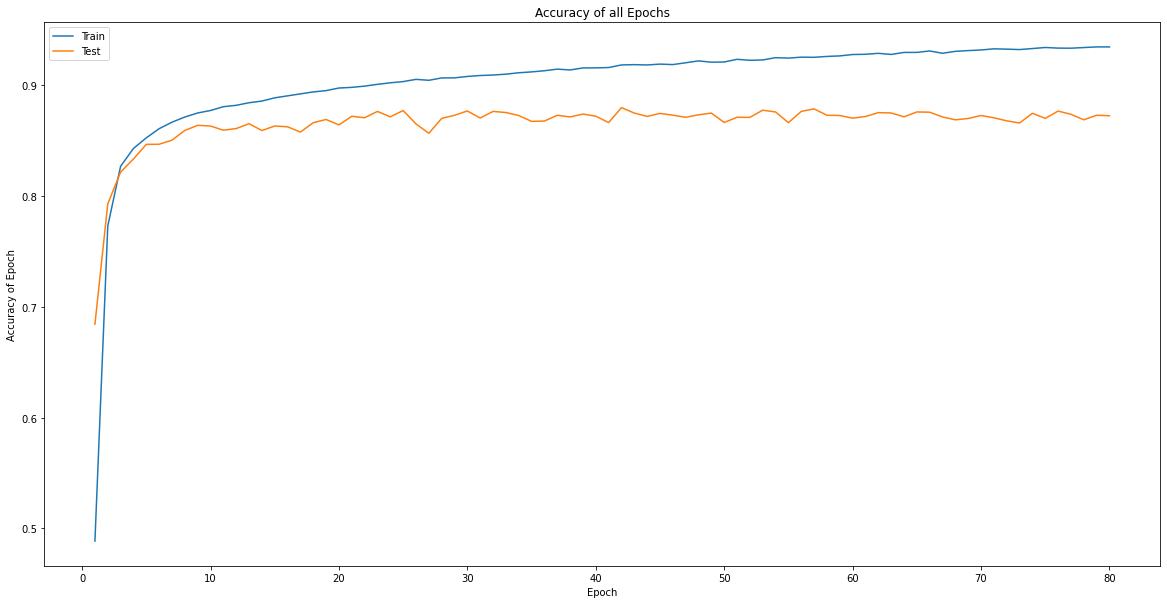

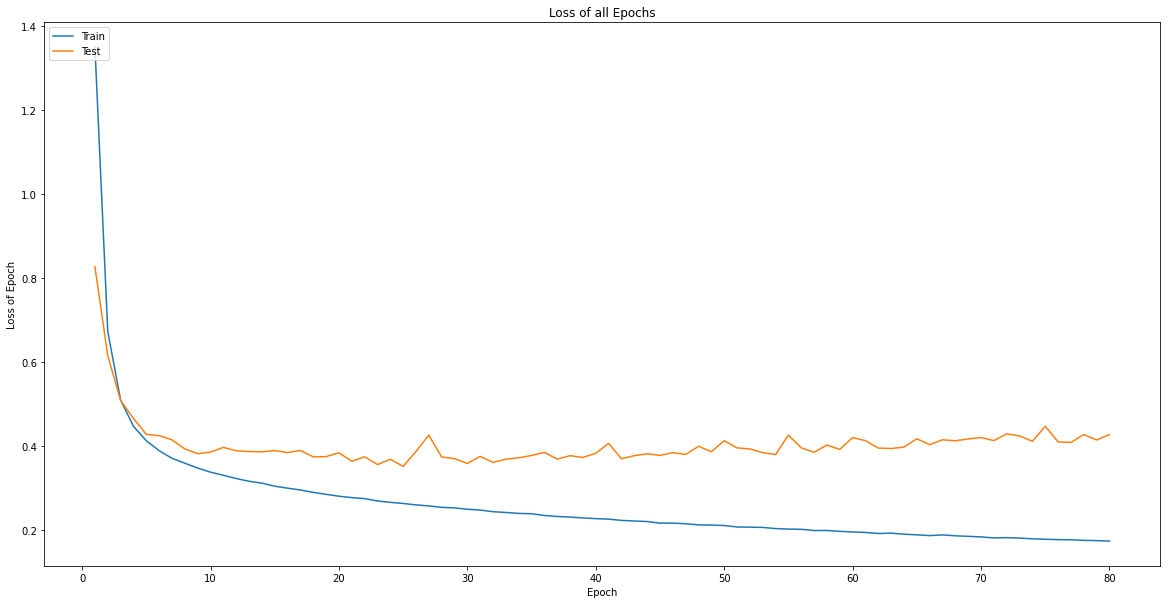

In [83]:
INPUT_SHAPE = traindata_df.shape[1]
LEARNING_RATE = 0.03
EPOCHS = 80
BATCH_SIZE = 32
TRAINLOADER = Dataloader(traindata_df, traintag_df, n_classes=10, batch_size=BATCH_SIZE, shuffle=True)
TESTLOADER = Dataloader(testdata_df, testtag_df, n_classes=10, batch_size=BATCH_SIZE, shuffle=True)


network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(40, activation=Relu(), weight_initializer='uniform')
network.add_layer(20, activation=Relu(), weight_initializer='uniform')
network.add_layer(10, activation=Identical(),  weight_initializer='normal')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER, print_results=False)

x_axis = list(range(1,81))
train_acc = log['train_accuracy']
test_acc = log['test_accuracy']
train_loss = log['train_loss']
test_loss = log['test_loss']

plt.figure(figsize=(20,10))
plt.plot(x_axis, train_acc)
plt.plot(x_axis, test_acc)
plt.title('Accuracy of all Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy of Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(x_axis, train_loss)
plt.plot(x_axis, test_loss)
plt.title('Loss of all Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss of Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Part 4

In [166]:
# def second_layer(self, input_data, input_type):
        
INPUT_SHAPE = traindata_df.shape[1]
LEARNING_RATE = 0.03
EPOCHS = 15
BATCH_SIZE = 32
TRAINLOADER = Dataloader(traindata_df, traintag_df, n_classes=10, batch_size=BATCH_SIZE, shuffle=True)
TESTLOADER = Dataloader(testdata_df, testtag_df, n_classes=10, batch_size=BATCH_SIZE, shuffle=True)


network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(40, activation=Relu(), weight_initializer='uniform')
network.add_layer(2, activation=Relu(), weight_initializer='uniform')
network.add_layer(10, activation=Identical(),  weight_initializer='normal')
network.set_training_param(loss=CrossEntropy(), lr=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)
w1, train_twod = network.second_layer(traindata_df, 'TRAIN')
w2, test_twod = network.second_layer(testdata_df, 'TEST')

Epoch 1:
	Train: Average Accuracy: 0.3488	   Average Loss: 1.6073
	Test:  Average Accuracy: 0.5089	   Average Loss: 1.1160
Epoch 2:
	Train: Average Accuracy: 0.5804	   Average Loss: 1.0398
	Test:  Average Accuracy: 0.5699	   Average Loss: 1.0257
Epoch 3:
	Train: Average Accuracy: 0.6361	   Average Loss: 0.9160
	Test:  Average Accuracy: 0.6684	   Average Loss: 0.8706
Epoch 4:
	Train: Average Accuracy: 0.6728	   Average Loss: 0.8362
	Test:  Average Accuracy: 0.6612	   Average Loss: 0.8613
Epoch 5:
	Train: Average Accuracy: 0.7233	   Average Loss: 0.7751
	Test:  Average Accuracy: 0.7505	   Average Loss: 0.7751
Epoch 6:
	Train: Average Accuracy: 0.7697	   Average Loss: 0.7191
	Test:  Average Accuracy: 0.7633	   Average Loss: 0.7290
Epoch 7:
	Train: Average Accuracy: 0.7811	   Average Loss: 0.6715
	Test:  Average Accuracy: 0.7405	   Average Loss: 0.7616
Epoch 8:
	Train: Average Accuracy: 0.7915	   Average Loss: 0.6365
	Test:  Average Accuracy: 0.7940	   Average Loss: 0.6544
Epoch 9:
	Train:

### As we can see below and by comparing the results with their corresponding tag, we can understand that data with tags 2,4 and 6 are hard to separete due to their plot entanglement. On the other hand, classed like 7 and 5 or 9 and 3 are easy to distinguish.

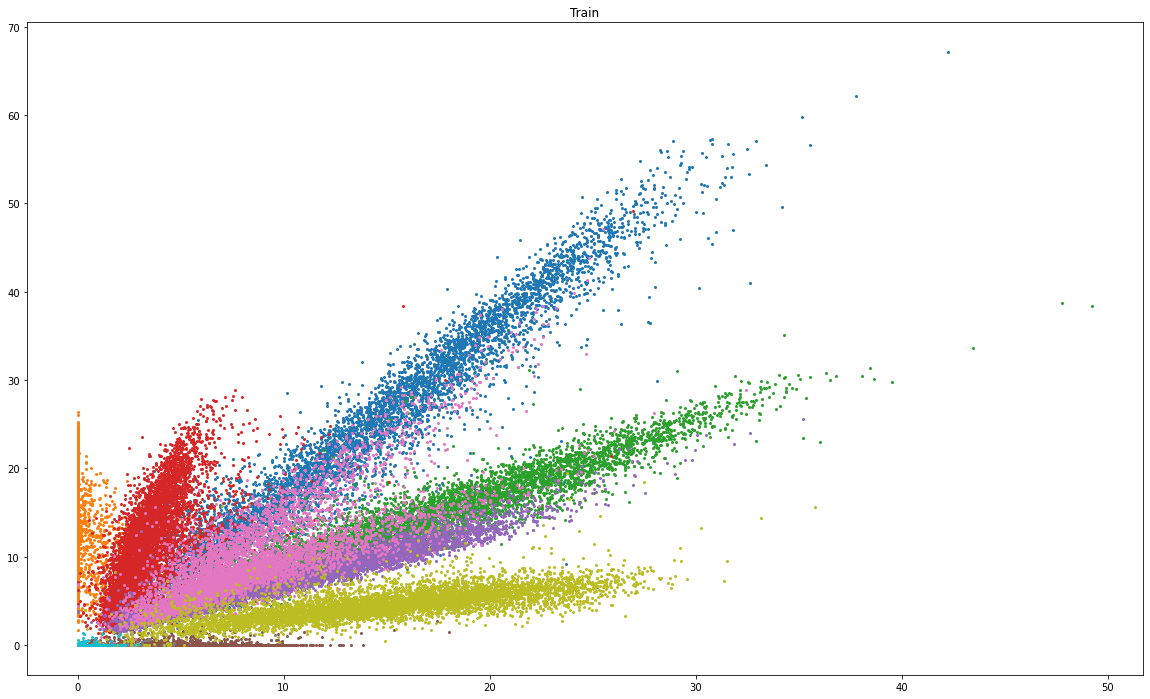

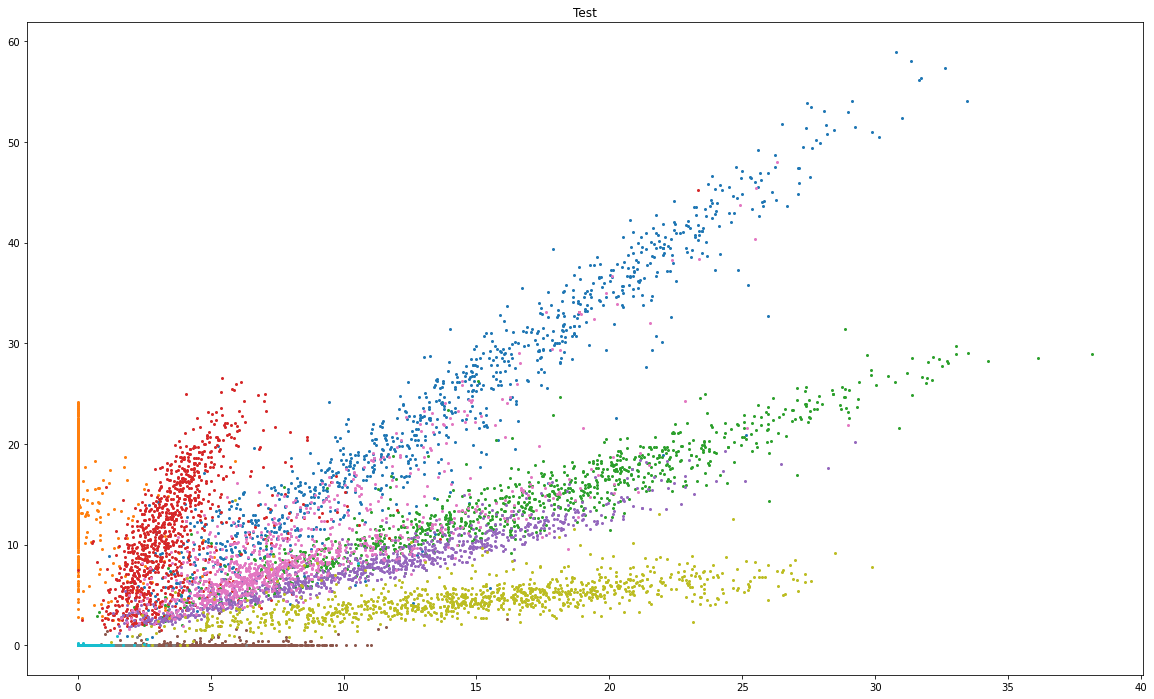

In [226]:
plt.figure(figsize=(20,12))
for i in range(len(models)):
    x_axis = list()
    y_axis = list()
    for j in train_tag_list[i]:
        x_val = train_twod[j, 0]
        y_val = train_twod[j, 1]
        x_axis.append(x_val)
        y_axis.append(y_val)
    plt.scatter(x_axis, y_axis, s=4)
plt.title('Train')
plt.show()

plt.figure(figsize=(20,12))
for i in range(len(models)):
    x_axis = list()
    y_axis = list()
    for j in test_tag_list[i]:
        x_val = test_twod[j, 0]
        y_val = test_twod[j, 1]
        x_axis.append(x_val)
        y_axis.append(y_val)
    plt.scatter(x_axis, y_axis, s=4)
plt.title('Test')
plt.show()